# CIFAR-100 Image Classification using ResNet in PyTorch


### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt


Torchvision is a library for computer vision tasks, built on top of PyTorch. It provides datasets, data loaders, and data transforms for image classification tasks.

---

### Data transformation and augmentation

In [2]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025)) #mean and standard deviation of the dataset to normalize the data
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

### Loading Data

In [3]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

Files already downloaded and verified


_____

In [4]:
# prints the shape and tensor of first image-label pair
for image, label in train_data:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[ 2.4495,  2.4495,  2.4495,  ..., -0.1636,  0.7140,  1.1625],
         [ 2.4300,  2.4300,  2.4300,  ...,  0.3240,  0.6165,  0.7920],
         [ 2.4495,  2.4495,  2.4495,  ...,  1.0260,  1.6110,  1.2795],
         ...,
         [ 1.0260,  0.9675,  0.5190,  ..., -0.6706, -0.9436, -1.0996],
         [ 0.5580,  0.6165,  0.5385,  ..., -0.9631, -1.1581, -1.5676],
         [ 0.2070,  0.0900,  0.2070,  ..., -1.0411, -1.2556, -1.9381]],

        [[ 2.5833,  2.5833,  2.5833,  ...,  0.1755,  1.0636,  1.4781],
         [ 2.5636,  2.5636,  2.5636,  ...,  0.5899,  0.8662,  1.0241],
         [ 2.5833,  2.5833,  2.5833,  ...,  1.3794,  1.9715,  1.5965],
         ...,
         [ 1.8925,  1.8136,  1.2807,  ..., -0.7719, -1.1271, -1.3442],
         [ 1.4781,  1.4978,  1.3004,  ..., -0.9692, -1.2653, -1.7784],
         [ 1.0833,  0.9649,  1.0044,  ..., -0.9297, -1.2258, -2.1139]],

        [[ 2.7600,  2.7600,  2.7600,  ..., -0.4934,  0.3393,  1

#### For training dataset

In [10]:
# Counts the number of occurrences of each class label in the train_data dataset.

train_classes_items = dict()

for train_item in train_data:
    label = train_data.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'cattle': 500,
 'dinosaur': 500,
 'apple': 500,
 'boy': 500,
 'aquarium_fish': 500,
 'telephone': 500,
 'train': 500,
 'cup': 500,
 'cloud': 500,
 'elephant': 500,
 'keyboard': 500,
 'willow_tree': 500,
 'sunflower': 500,
 'castle': 500,
 'sea': 500,
 'bicycle': 500,
 'wolf': 500,
 'squirrel': 500,
 'shrew': 500,
 'pine_tree': 500,
 'rose': 500,
 'television': 500,
 'table': 500,
 'possum': 500,
 'oak_tree': 500,
 'leopard': 500,
 'maple_tree': 500,
 'rabbit': 500,
 'chimpanzee': 500,
 'clock': 500,
 'streetcar': 500,
 'cockroach': 500,
 'snake': 500,
 'lobster': 500,
 'mountain': 500,
 'palm_tree': 500,
 'skyscraper': 500,
 'tractor': 500,
 'shark': 500,
 'butterfly': 500,
 'bottle': 500,
 'bee': 500,
 'chair': 500,
 'woman': 500,
 'hamster': 500,
 'otter': 500,
 'seal': 500,
 'lion': 500,
 'mushroom': 500,
 'girl': 500,
 'sweet_pepper': 500,
 'forest': 500,
 'crocodile': 500,
 'orange': 500,
 'tulip': 500,
 'mouse': 500,
 'camel': 500,
 'caterpillar': 500,
 'man': 500,
 'skunk': 500

#### For testing dataset


In [7]:
# Counts the number of occurrences of each class label in the test_data dataset.

test_classes_items = dict()
for test_item in test_data:
    label = test_data.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

{'mountain': 100,
 'forest': 100,
 'seal': 100,
 'mushroom': 100,
 'sea': 100,
 'tulip': 100,
 'camel': 100,
 'butterfly': 100,
 'cloud': 100,
 'apple': 100,
 'skunk': 100,
 'streetcar': 100,
 'rocket': 100,
 'lamp': 100,
 'lion': 100,
 'wolf': 100,
 'rose': 100,
 'orange': 100,
 'dinosaur': 100,
 'chimpanzee': 100,
 'can': 100,
 'keyboard': 100,
 'bicycle': 100,
 'chair': 100,
 'plate': 100,
 'lawn_mower': 100,
 'turtle': 100,
 'palm_tree': 100,
 'shark': 100,
 'pickup_truck': 100,
 'boy': 100,
 'couch': 100,
 'house': 100,
 'porcupine': 100,
 'cockroach': 100,
 'clock': 100,
 'castle': 100,
 'beaver': 100,
 'bee': 100,
 'bottle': 100,
 'pear': 100,
 'baby': 100,
 'flatfish': 100,
 'oak_tree': 100,
 'leopard': 100,
 'snail': 100,
 'crocodile': 100,
 'rabbit': 100,
 'beetle': 100,
 'girl': 100,
 'sunflower': 100,
 'raccoon': 100,
 'train': 100,
 'ray': 100,
 'trout': 100,
 'bowl': 100,
 'snake': 100,
 'orchid': 100,
 'tractor': 100,
 'caterpillar': 100,
 'bus': 100,
 'mouse': 100,
 'cr

Define a batch size of 128 and create two data loaders. <br>

The DataLoader class from PyTorch is used to create these data loaders, which provide an iterator over the dataset and allow for efficient data loading and batching. 

In [5]:
BATCH_SIZE = 128
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

---

### Visualization

The code creates a data loader, imshow, iterates over the train_8_samples dataset, displays a grid of images and prints class labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7615613..1.88].


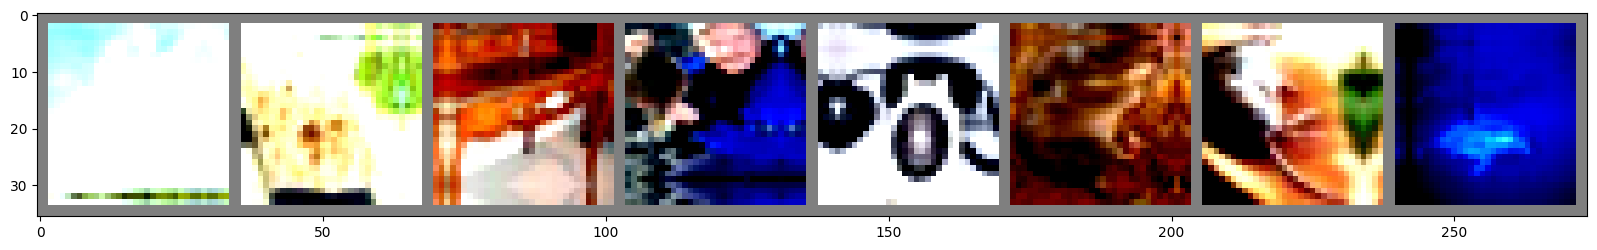

cloud               flatfish            table               flatfish            telephone           shrew               shrew               shark               


In [6]:
# for 8 images
train_8_samples = DataLoader(train_data, 8, num_workers=4, pin_memory=True, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels using loop (for multi-processing)
for images, labels in train_8_samples:
    imshow(torchvision.utils.make_grid(images))
    print(''.join(f'{train_data.classes[labels[j]]:20s}' for j in range(len(labels))))  # Use len(labels) for dynamic printing
    break  # To process 1 batch (8 images)

### Get CUDA ready

In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
else:
    device = torch.device("cpu")
print("using", device, "device")

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4070 Laptop GPU
__CUDA Device Total Memory [GB]: 8.585216
using cuda device


In [3]:
import time

matrix_size = 32*512

x = torch.randn(matrix_size, matrix_size)
y = torch.randn(matrix_size, matrix_size)

print("************* CPU SPEED *******************")
start = time.time()
result = torch.matmul(x, y)
print(time.time() - start)
print("verify device:", result.device)

x_gpu = x.to(device)
y_gpu = y.to(device)
torch.cuda.synchronize()

for i in range(3):
    print("************* GPU SPEED *******************")
    start = time.time()
    result_gpu = torch.matmul(x_gpu, y_gpu)
    torch.cuda.synchronize()
    print(time.time() - start)
    print("verify device:", result_gpu.device)

************* CPU SPEED *******************
18.24213409423828
verify device: cpu
************* GPU SPEED *******************
1.5627233982086182
verify device: cuda:0
************* GPU SPEED *******************
1.16263747215271
verify device: cuda:0
************* GPU SPEED *******************
0.8957462310791016
verify device: cuda:0


In [7]:
# Returns a PyTorch device object for either the GPU or the CPU
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

# Moves PyTorch tensor to the specified device
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

# Class wrapper around a PyTorch data loader that automatically moves each batch of data to the specified device
class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device

    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)

    def __len__(self):
        return len(self.data)

Ensures that data and models are always on the correct device

In [8]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cuda


Function to calculate the accuracy of a model's predictions.

`_, predictions` is used to find the maximum value of predicted output from a model.

The code compares predicted class labels with actual labels, creating a tensor of booleans. The sum is converted to a Python integer, and the total number of predictions is calculated, wrapped in a PyTorch tensor.

In [9]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))